In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- Load the NPZ Files ---

train_data = np.load('train-dataset.npz')
X_train = train_data["X"]
y_train = train_data["y"]

valid_data = np.load('valid-dataset.npz')
X_valid = valid_data["X"]
y_valid = valid_data["y"]

test_data = np.load('test-dataset.npz')
X_test = test_data["X"]
y_test = test_data["y"]

# --- Data Shape ---
# 이전 단계에서 채널 차원이 마지막에 위치하도록 재배열했으므로,
# X_train의 shape는 (samples, height, width, channels)이고, channels가 2입니다.
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape, "y_valid shape:", y_valid.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

# --- Define Residual Block ---
def res_block(input_tensor, filters, kernel_size=(3,3), strides=(1,1), weight_decay=0.1):
    """
    A basic residual block with two convolutional layers and a skip connection.
    """
    # Main branch: two Conv2D layers with BatchNormalization and ReLU activation
    x = Conv2D(filters, kernel_size, padding='same', strides=strides,
               activation='relu', kernel_regularizer=l2(weight_decay))(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding='same', strides=(1,1),
               activation=None, kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)

    # Shortcut branch: adjust input dimensions if necessary using a 1x1 convolution
    shortcut = input_tensor
    if shortcut.shape[-1] != filters or strides != (1,1):
        shortcut = Conv2D(filters, (1,1), strides=strides, padding='same',
                          kernel_regularizer=l2(weight_decay))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add the main branch and shortcut, then apply ReLU activation
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x



X_train shape: (5056, 2, 13, 388) y_train shape: (5056, 4)
X_valid shape: (1936, 2, 13, 388) y_valid shape: (1936, 4)
X_test shape: (502, 2, 13, 388) y_test shape: (502, 4)


In [5]:
# --- Build the Model ---
# 이제 X_train의 shape는 (samples, height, width, channels)이며, channels는 2입니다.
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
inputs = Input(shape=input_shape)
num_classes = y_train.shape[1]

# Initial convolution block: similar to the original model's first Conv2D (32 filters)
x = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.1))(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2), padding='same')(x)

# Residual block with 64 filters
x = res_block(x, 64, strides=(1,1), weight_decay=0.1)
x = MaxPooling2D((2,2), padding='same')(x)

# Residual block with 128 filters
x = res_block(x, 128, strides=(1,1), weight_decay=0.1)
x = MaxPooling2D((2,2), padding='same')(x)

# Residual block with 256 filters
x = res_block(x, 256, strides=(1,1), weight_decay=0.1)
x = MaxPooling2D((2,2), padding='same')(x)

# Additional residual block with 256 filters (without additional pooling)
x = res_block(x, 256, strides=(1,1), weight_decay=0.1)

# Fully connected layers: mirroring the original model's Dense structure
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.1))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.1))(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.1))(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.1))(x)
x = Dropout(0.4)(x)

# Output layer: num_classes is determined by the one-hot encoded y_train dimension
outputs = Dense(num_classes, activation='softmax')(x)

# Create and compile the model
model_resnet = Model(inputs=inputs, outputs=outputs)
model_resnet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
model_resnet.summary()




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 2, 13, 388)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 2, 13, 32)      │        111,776 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 2, 13, 32)      │            128 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 1, 7, 32)       │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 1, 7, 64)       │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 1, 7, 64)       │            256 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 1, 7, 64)       │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 1, 7, 64)       │          2,112 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 1, 7, 64)       │            256 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 1, 7, 64)       │            256 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 1, 7, 64)       │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 1, 7, 64)       │              0 │ add_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 1, 4, 64)       │              0 │ activation_4[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 1, 4, 128)      │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 1, 4, 128)      │            512 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 2,809,380 (10.72 MB)

 Trainable params: 2,805,604 (10.70 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [6]:
# --- Train the Model ---
history = model_resnet.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=100,
    batch_size=32
)

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 47s 217ms/step - accuracy: 0.2638 - loss: 225.5652 - val_accuracy: 0.2567 - val_loss: 152.7561
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 32s 205ms/step - accuracy: 0.2700 - loss: 137.8462 - val_accuracy: 0.2696 - val_loss: 101.7630
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 42s 214ms/step - accuracy: 0.2595 - loss: 93.3469 - val_accuracy: 0.2836 - val_loss: 71.7845
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 34s 213ms/step - accuracy: 0.2710 - loss: 66.2445 - val_accuracy: 0.2794 - val_loss: 51.6189
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 40s 204ms/step - accuracy: 0.3028 - loss: 47.6994 - val_accuracy: 0.3125 - val_loss: 37.3149
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 33s 208ms/step - accuracy: 0.3328 - loss: 34.5064 - val_accuracy: 0.3202 - val_loss: 27.1067
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 34s 214ms/step - accuracy: 0.3542 - loss: 25.1017 - val_accuracy: 0.3228 - val_loss: 19.8712
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 40s 209ms/step - 

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2642 - loss: 3.0520
Final Accuracy on Test Set: 0.2749004065990448
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
              precision    recall  f1-score   support

     african       0.09      0.54      0.16        24
   australia       0.23      0.34      0.27        90
     england       0.54      0.17      0.26       298
      indian       0.33      0.47      0.39        90

    accuracy                           0.27       502
   macro avg       0.30      0.38      0.27       502
weighted avg       0.43      0.27      0.28       502



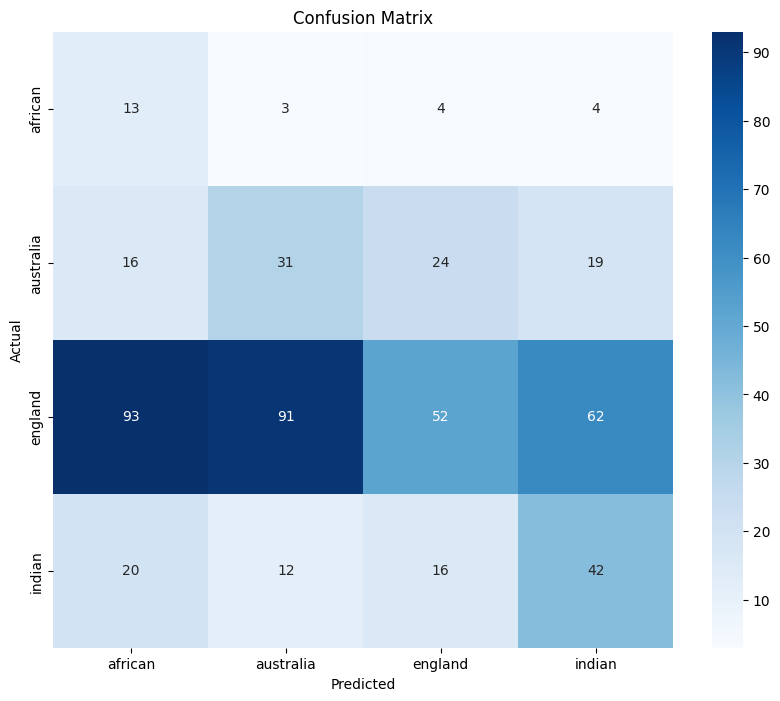

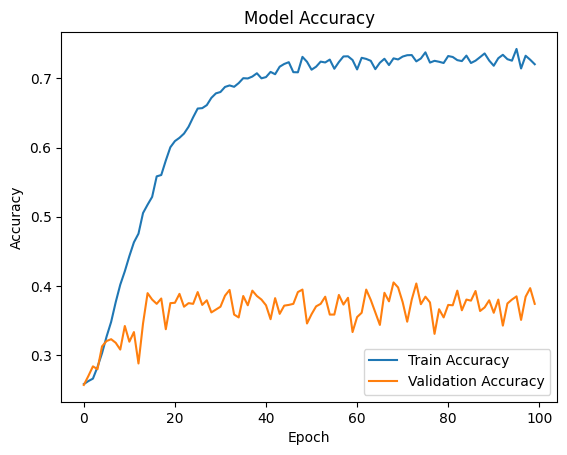

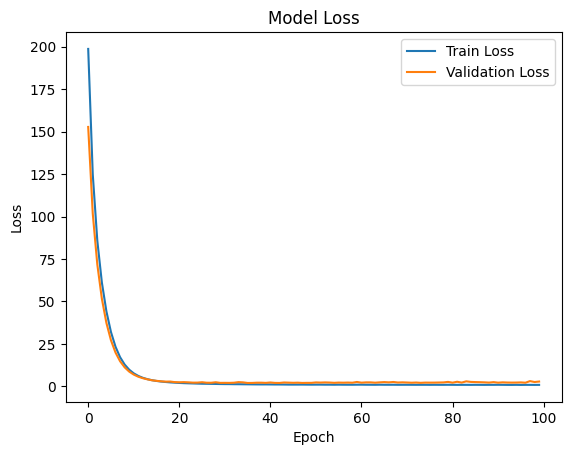

/content/model_mfcc.h5

In [7]:
# Accent label mapping
label_mapping = {0: 'african', 1: 'australia', 2: 'england', 3: 'indian'}
target_names = [label_mapping[i] for i in range(len(label_mapping))]

# --- Evaluate the Model on Test Data ---
test_loss, test_accuracy = model_resnet.evaluate(X_test, y_test)
print("Final Accuracy on Test Set:", test_accuracy)

# --- Confusion Matrix and Classification Report ---
y_pred = model_resnet.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=target_names))
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- Plot Training History ---
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.show()

# --- Save the Model ---
model_resnet.save("model_mfcc.h5")

# For environments that support file links (like Kaggle or Jupyter Notebook)
from IPython.display import FileLink
FileLink('model_mfcc.h5')
